# Q1. Data

In [191]:
import pandas as pd
import numpy as np
import ijson
from tqdm.notebook import tqdm
import networkx as nx
import community  # Louvain method
import matplotlib.pyplot as plt
import ast
import itertools

converting the Json file to CSV and then dataframe keeping only the most important information for memory issues.\
font: https://www.kaggle.com/code/devintheai/citation-network-eda
We adapted the code found in this link to extract all the information, including the autors' information.

In [40]:
"""
PAPERS = []

with open("./dblp.v12.json", "rb") as f:
    for i, element in tqdm(enumerate(ijson.items(f, "item"))):
        paper = {}
        paper['id'] = element['id']
        paper['title'] = element['title']

        authors = element.get('authors')
        if authors:
            paper['num_authors'] = len(authors)
            # joining all authors in a list
            paper['authors'] = [auth for auth in authors]
        
        year = element.get('year')
        if year:
            paper['year']= year
        else:
            paper['year']= np.nan
        
        n_citation= element.get('n_citation')
        if n_citation:
             paper['n_citation']= element['n_citation']
        else:
            paper['n_citation']= 0
        
        doc_type= element.get('doc_type') 
        if doc_type:
            paper['doc_type']= element['doc_type']
        else:
            paper['doc_type']= np.nan      

        references= element.get('references')
        if references:
            paper['reference_count']= len(references)
            # joining all refs id in a `;` seperated string  
            paper['references']= ';'.join([str(int(r)) for r in references])
        else:
            paper['reference_count']= np.nan 
            paper['references']= np.nan
        
        doi = element.get('doi')
        if doi:
            paper['doi']= f"https://doi.org/{element['doi']}"
        else:
            paper['doi']= np.nan               
        
        
        PAPERS.append(paper)
"""

'\nPAPERS = []\n\nwith open("./dblp.v12.json", "rb") as f:\n    for i, element in tqdm(enumerate(ijson.items(f, "item"))):\n        paper = {}\n        paper[\'id\'] = element[\'id\']\n        paper[\'title\'] = element[\'title\']\n\n        authors = element.get(\'authors\')\n        if authors:\n            paper[\'num_authors\'] = len(authors)\n            # joining all authors in a list\n            paper[\'authors\'] = [auth for auth in authors]\n        \n        year = element.get(\'year\')\n        if year:\n            paper[\'year\']= year\n        else:\n            paper[\'year\']= np.nan\n        \n        n_citation= element.get(\'n_citation\')\n        if n_citation:\n             paper[\'n_citation\']= element[\'n_citation\']\n        else:\n            paper[\'n_citation\']= 0\n        \n        doc_type= element.get(\'doc_type\') \n        if doc_type:\n            paper[\'doc_type\']= element[\'doc_type\']\n        else:\n            paper[\'doc_type\']= np.nan      

Now we'll convert the information extracted in a dataframe and save them in a csv file, called "citations_network.csv"

In [41]:
"""
data = pd.DataFrame(PAPERS)
data.head()
data.to_csv("citations_network.csv", index=False)
"""

'\ndata = pd.DataFrame(PAPERS)\ndata.head()\ndata.to_csv("citations_network.csv", index=False)\n'

our new dataset to create our subgraph for our investigation. Considering only the most connected componet of the graph.

In [42]:
df = pd.read_csv('./citations_network.csv')

/var/folders/d6/sz5pbmks2gs12gkp2yzr1gl00000gn/T/ipykernel_60325/2258685613.py:1: DtypeWarning: Columns (0,2,5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./citations_network.csv')


In [44]:
df.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,1091,Preliminary Design of a Network Protocol Learn...,8.0,"[{'name': 'Makoto Satoh', 'org': 'Shinshu Univ...",2013.0,1,Conference,2.0,2005687710;2018037215,https://doi.org/10.1007/978-3-642-39476-8_19
1,1388,Further Results on Independence in Direct-Prod...,1.0,"[{'name': 'Pranava K. Jha', 'id': 2718958994}]",2000.0,1,Journal,NaN,NaN,NaN
2,1674,A methodology for the physically accurate visu...,2.0,"[{'name': 'G. Beale', 'org': 'Archaeological C...",2011.0,1,Conference,15.0,1535888970;1992876689;1993710814;2035653341;20...,https://doi.org/10.2312/VAST/VAST11/137-144
3,1688,"Comparison of GARCH, Neural Network and Suppor...",4.0,"[{'name': 'Altaf Hossain', 'org': 'Department ...",2009.0,6,Conference,3.0,1560724230;1986968751;2156909104,https://doi.org/10.1007/978-3-642-11164-8_97
4,5411,COMPARING GNG3D AND QUADRIC ERROR METRICS METH...,4.0,"[{'name': 'Rafael Álvarez', 'id': 2125293936},...",2009.0,0,Conference,NaN,NaN,NaN


In [46]:
df.shape

(4894402, 10)

## Data pre-processing
1. identify the top **10,000** papers with the highest number of citations
   
We just sorted the entire dataset in descending order according to the number of citation of each paper, and kept the first 10,000 rows.


In [50]:
# Convert 'n_citation' column to numeric type if it contains mixed data types
df['n_citation'] = pd.to_numeric(df['n_citation'], errors='coerce')

# Sort the DataFrame by 'n_citation' column in descending order
df_sorted = df.sort_values(by='n_citation', ascending=False)

# Take the top 10000 rows after sorting and reset the index
df_s = df_sorted.head(10000).reset_index(drop=True)

In [48]:
# converting the authors' information from string to list
df_s['authors'] = df_s['authors'].apply(lambda row: ast.literal_eval(row))

In [52]:
df_s.head()

,id,title,num_authors,authors,year,n_citation,doc_type,reference_count,references,doi
0,2041404167,The Mathematical Theory of Communication,1.0,"[{'name': 'C. E. Shannon', 'org': 'External Or...",1949.0,48327.0,Book,NaN,NaN,NaN
1,1639032689,"Genetic algorithms in search, optimization, an...",1.0,"[{'name': 'David E. Goldberg', 'id': 2102678951}]",1989.0,44175.0,Book,NaN,NaN,NaN
2,2912565176,Fuzzy sets,1.0,"[{'name': 'Lotfi A. Zadeh', 'id': 2252586558}]",1996.0,42437.0,NaN,NaN,NaN,NaN
3,2151103935,Distinctive Image Features from Scale-Invarian...,1.0,"[{'name': 'David G. Lowe', 'org': 'Computer Sc...",2004.0,35541.0,Journal,33.0,19720318;1541642243;1560959218;1676552347;1681...,https://doi.org/10.1023/B:VISI.0000029664.9961...
4,2911964244,Random Forests,1.0,"[{'name': 'Leo Breiman', 'org': 'Statistics De...",2001.0,34741.0,NaN,11.0,1507255258;1580948147;1605688901;1975846642;20...,https://doi.org/10.1023/A:1010933404324


### Citation graph
- Representation of the paper's *citation relationships*, where each node is a paper and the edge between two nodes is present only if the starting node cites the second node.
- Unweighted
- Directed

2. The **nodes** of the graph

In [53]:
# the nodes of the graph will be all the unique rows that are present in the dataset

# creating the directed graph
cit_G = nx.DiGraph(name = 'Citation Graph')

# adding the nodes and the attributes (the columns of the dataset)
for i, pap in df_s.iterrows():
    node = pap['id']
    attributes = {}
    for el in list(df_s.columns)[1:]:
        attributes[el] = pap[el]
    cit_G.add_node(node, **attributes)

print(f'number of nodes in the Citation Graph: {len(cit_G.nodes())}')

number of nodes in the Citation Graph: 10000


3. The **edges** of the graph

The edges are defined by simply connecting each edge with all the paper's ids that specific paper cites; those can be found in the feature *references*.\
Those ids have been stored in a string separated by the ";", so what we'll do is to create a dictionary that is structured in the following way:
```python
result_dict = {node_A : [node_B, node_c...], node_B : [node_i, ... ]}
```
where the key is the starting node and its value is a list of all the reachable nodes from it.

In [26]:
# the edges are all the papers' ids in the 'references' column
def citation_dict(row, d={}):
    if pd.notnull(row['references']):
        d[row['id']] = [int(cit) for cit in row['references'].split(';')]
    return d

# apply the function to each row in the DataFrame to save the citation's relationship in a dictionary
result_dict = {} # {node_A : [node_B, node_c...], node_B : [node_i, ... ]}
for idx, row in df_s.iterrows():
    result_dict = citation_dict(row, result_dict)

Now we'll use the dictionary ```result_dict``` to create the directed edges in the graph

In [27]:
for start in result_dict.keys():
    for end in result_dict[start]:
        cit_G.add_edge(start, end)

If we're interested in a rapresentatin of a portion of the graph (a subgraph of about 20 nodes, for the sake of a clearer view)

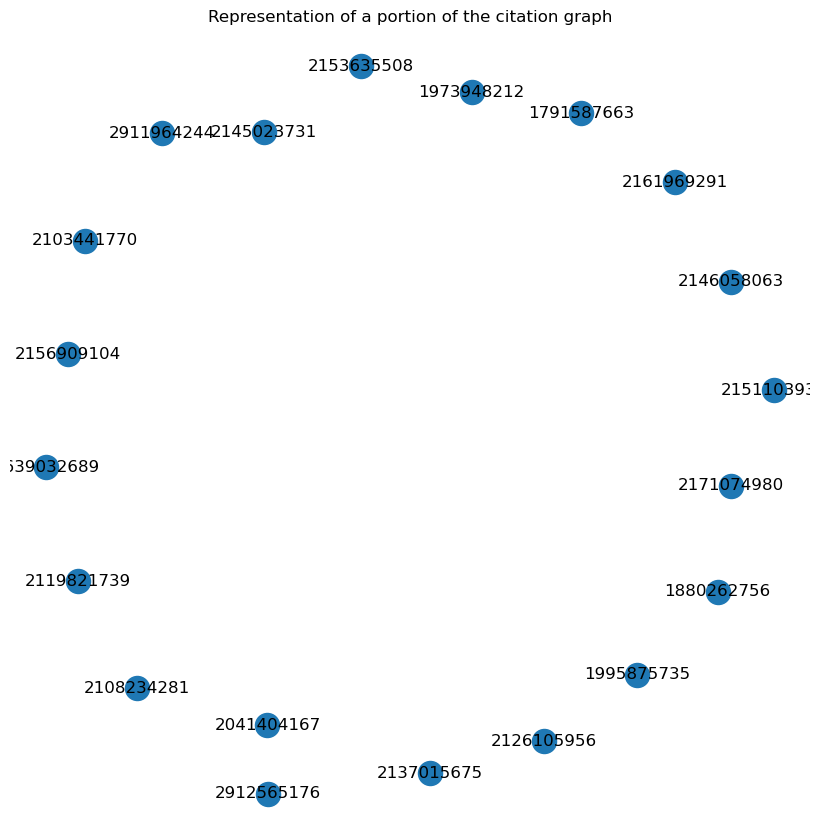

In [61]:
# creating a subgraph of ten nodes
subgraph = cit_G.subgraph(list(cit_G.nodes())[:20])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(8,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

### Collaboration graph
- Represents the *collaborations of the paper's authors*, where each node is an author and the undirected edge between two nodes represents the fact that those two authors have collaborated in a research paper. 
- Weighted: the weight will be the the number of research papers the couple of authors have worked on together.
- Undirected

2. The **nodes** of the graph
3. The **edges** of the graph: undirected and weighted

In [29]:
collab_G = nx.Graph(name = 'Collaboration Graph') 

In [30]:
tqdm.pandas()

# dictionary to count the collaborations between each author's couple 
author_collaborations = {}
for authors_list in df_s['authors']:
    author_ids = [author['id'] for author in authors_list]  # extract the author's id for each paper
    author_combinations = itertools.combinations(author_ids, 2) # find all the possible combinations of the authors for the current paper
    
    for pair in author_combinations: # keep the count of the collaborations for each author's couple
        pair = tuple(sorted(pair))  # sort the ids to keep coherence in the couple
        if pair not in author_collaborations.keys():
            author_collaborations[pair] = 1
        else:
            author_collaborations[pair] += 1

# now create the graph with the author's couple of edges, networkX will automatically create the nodes if not present already

for authors, num_collab in author_collaborations.items():
    author1, author2 = authors
    collab_G.add_edge(author1, author2, weight=num_collab) # create the graph with the weighted edges: the number of times each author worked with the other

# now we have to add all the authors that have never collaborated with anyone else  
def apply_record(G, data):
  authors_list = []
  for author in data['authors']:
    authors_list.append(author['id'])
    G.add_node(author['id'], name=author['name'])
    if 'org' in author:
      G.nodes()[author['id']]['org'] = author['org']

df_s.progress_apply(lambda row: apply_record(collab_G, row), axis=1)

print(f'number of nodes in the Collaboration Graph: {len(collab_G.nodes())}')
print(f'number of edges in the Collaboration Graph: {len(collab_G.edges())}')

  0%|          | 0/10000 [00:00<?, ?it/s]

number of nodes in the Collaboration Graph: 21232
number of edges in the Collaboration Graph: 136463


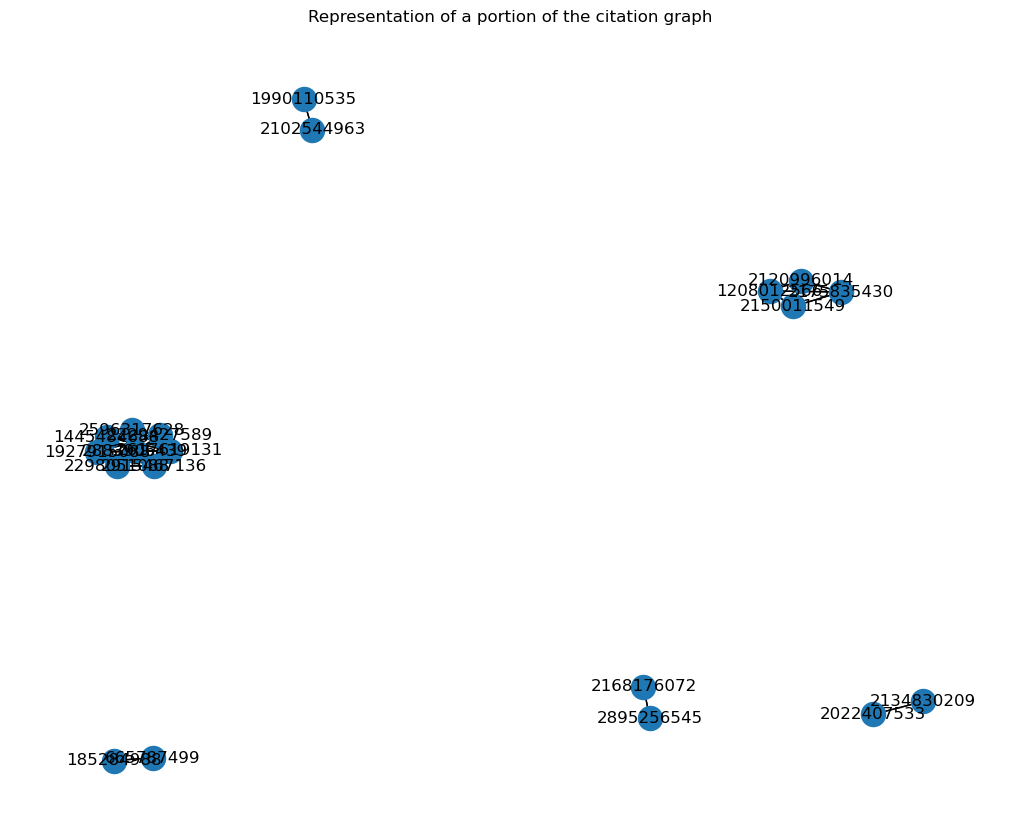

In [63]:
# creating a subgraph of 20 nodes
subgraph = collab_G.subgraph(list(collab_G.nodes())[:20])
position = nx.spring_layout(subgraph)
plt.figure(figsize=(10,8))
nx.draw(subgraph, with_labels=True, pos= position)
nx.draw_networkx_edges(subgraph, pos=position)
plt.title('Representation of a portion of the citation graph')
plt.show()

As a final step, we can save the graphs in a GraphML file

In [64]:
nx.write_graphml(collab_G, "Collaboration_Graph.graphml")

# in order to save the citation graph, we have to remove the author attribute, because is a list and is not supported by GraphML
for node in cit_G.nodes():
    if 'authors' in cit_G.nodes[node]:
        del cit_G.nodes[node]['authors']
nx.write_graphml(cit_G, "Citation_Graph.graphml")

# 2. Controlling system

## Functionality 1 - Graph's features

In [68]:
def read_graphs():
    citation_graph = nx.read_graphml('./Citation_Graph.graphml')
    collaboration_graph = nx.read_graphml('./Collaboration_Graph.graphml')
    return citation_graph, collaboration_graph

# Read graphs
citation_graph, collaboration_graph = read_graphs()

A density of 0 means that the number of edges in the graph is close to the minimum number of edges needed for a graph of that size. It implies the graph is relatively sparse, with fewer connections between nodes compared to the maximum possible connections.

For some types of networks (e.g., social networks, citation networks), sparsity might be natural. For instance, not every node (person, paper, etc.) is connected to every other node.

In [99]:
def graph_features(graph, graph_name):
    print(graph_name, "graph :")

    # number of nodes and edges:
    number_of_nodes = graph.number_of_nodes()
    number_of_edges = graph.number_of_edges()
    print("Number of Nodes:", number_of_nodes)
    print("Number of Edges:", number_of_edges)
    
    # Calculate the density of the graph
    density = nx.density(graph)
    print("Density: ", density)

    # Degree histogram returns a list of counts where the index is the degree
    degree_distribution = nx.degree_histogram(graph)
    print("Graph degree distribution: ", degree_distribution)

    # Calculate the average degree of the graph
    avg_degree = sum(dict(graph.degree()).values()) / len(graph)
    print("Average degree of the graph:", avg_degree)

    # Calculate degrees of all nodes
    degrees = dict(graph.degree())
    
    # Calculate the 95th percentile of the degree distribution
    percentile_95 = np.percentile(list(degrees.values()), 95)
    
    # Identify nodes that are hubs (nodes with degrees higher than the 95th percentile)
    hubs = [node for node, degree in degrees.items() if degree > percentile_95]
    
    print("Graph hubs (nodes with degrees higher than the 95th percentile):")
    print(hubs)

    # If the density of the graph is close to 1, it's considered dense.
    # If the density is closer to 0, it's considered sparse.
    
    # Set a threshold for determining if the graph is dense or sparse
    threshold = 0.0005  # we assigned 0.0005 to the threshold, to divide citation and collabration graphs into 2 groups of sparse and dense.
    is_dense = False
    
    if density >= threshold:
        print("The graph is dense.")
        is_dense = True
    else:
        print("The graph is sparse.")
        is_dense = False
    print("----------------------------------------------------")

    # return number_of_nodes, number_of_edges, degree_distribution, avg_degree, hubs, is_dense

In [100]:
# Test method-1
graph_features(citation_graph, "citation")
graph_features(collaboration_graph, "collaboration")

citation graph :
Number of Nodes: 10000
Number of Edges: 0
Density:  0
Graph degree distribution:  [10000]
Average degree of the graph: 0.0
Graph hubs (nodes with degrees higher than the 95th percentile):
[]
The graph is sparse.
----------------------------------------------------
collaboration graph :
Number of Nodes: 21232
Number of Edges: 136463
Density:  0.0006054573481490804
Graph degree distribution:  [1030, 3231, 3493, 2714, 1860, 1313, 995, 695, 652, 492, 373, 437, 343, 272, 145, 206, 160, 168, 143, 119, 86, 105, 97, 36, 48, 86, 29, 64, 61, 98, 40, 59, 44, 11, 127, 16, 24, 33, 9, 47, 12, 56, 38, 21, 9, 5, 65, 53, 7, 14, 15, 3, 9, 4, 35, 19, 3, 2, 5, 5, 22, 4, 0, 7, 6, 1, 2, 60, 2, 2, 1, 0, 4, 1, 4, 73, 4, 1, 2, 1, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 1, 7, 1, 0, 85, 0, 3, 1, 2, 3, 0, 0, 0, 2, 0, 3, 0, 0, 1, 1, 2, 87, 2, 4, 7, 1, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 4, 1, 1, 0, 1, 0, 40, 0, 3, 1, 1, 1, 0, 41, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 2, 1, 1, 0, 1, 0, 0, 1, 2, 

## Functionality 2 - Nodes' contribution

In [111]:
def betweenness_of_first_10_nodes(graph, node, graph_name):
    # Calculate betweenness centrality for all nodes
    betweenness_centrality = nx.betweenness_centrality(collaboration_graph)
    
    # Get the first 10 nodes from the graph
    first_10_nodes = list(collaboration_graph.nodes())[:10]
    
    # Filter the betweenness centrality for the first 10 nodes
    betweenness_first_10 = {node: betweenness_centrality[node] for node in first_10_nodes}
    
    # Print the betweenness centrality for each of the first 10 nodes
    for node, centrality in betweenness_first_10.items():
        print(f"Node: {node}, Betweenness Centrality: {centrality}")

betweenness_of_first_10_nodes()

Node: 1990110535, Betweenness Centrality: 0.0
Node: 2102544963, Betweenness Centrality: 1.3311616761748218e-08
Node: 2168176072, Betweenness Centrality: 0.0005993585028347715
Node: 2895256545, Betweenness Centrality: 0.0
Node: 2022407533, Betweenness Centrality: 0.0008416555157772473
Node: 2134830209, Betweenness Centrality: 0.0
Node: 1445484688, Betweenness Centrality: 0.003094638209736223
Node: 2596317628, Betweenness Centrality: 0.0
Node: 2120996014, Betweenness Centrality: 1.3737588498120606e-05
Node: 2150011549, Betweenness Centrality: 0.0014994027632210256


In [112]:
def nodes_contribution(graph, node, graph_name):
    print(graph_name, "graph :")
    
    # Calculate Betweenness Centrality for all nodes
    betweenness = nx.betweenness_centrality(graph)
    
    # Get Betweenness Centrality for the specified node
    node_betweenness = betweenness.get(node)
    
    print(f"Betweenness Centrality of node {node}: {node_betweenness}")

    # Calculate PageRank centrality for all nodes
    pagerank = nx.pagerank(graph)
    
    # Get PageRank centrality for the specified node
    node_pagerank = pagerank.get(node)
    
    print(f"PageRank centrality of node {node}: {node_pagerank}")

    # Calculate Closeness Centrality for all nodes
    closeness = nx.closeness_centrality(graph)
    
    # Get Closeness Centrality for the specified node
    node_closeness = closeness.get(node)
    
    print(f"Closeness Centrality of node {node}: {node_closeness}")

    # Calculate Degree Centrality for all nodes
    degree_centrality = nx.degree_centrality(graph)
    
    # Get Degree Centrality for the specified node
    node_degree_centrality = degree_centrality.get(node)
    
    print(f"Degree Centrality of node {node}: {node_degree_centrality}")

    return node_betweenness, node_pagerank, node_closeness, node_degree_centrality


nodes_contribution(collaboration_graph, list(collaboration_graph.nodes())[1], "citation")

citation graph :
Betweenness Centrality of node 2102544963: 1.3311616761748218e-08
PageRank centrality of node 2102544963: 7.090991900019985e-05
Closeness Centrality of node 2102544963: 0.00018840374923460976
Degree Centrality of node 2102544963: 0.00018840374923460976


## Functionality 3 - Shortest ordered walk

In [155]:
def shortest_ordered_walk(graph, authors_a, a_1, a_n):
    # Check if a_1 and a_n are in the graph
    if a_1 not in graph.nodes() or a_n not in graph.nodes():
        return "One or more authors are not present in the graph."

    # Create a list to store the ordered nodes
    ordered_nodes = [a_1] + authors_a + [a_n]

    # Check if the nodes exist in the graph
    for i in range(len(ordered_nodes) - 1):
        if not nx.has_path(graph, ordered_nodes[i], ordered_nodes[i + 1]):
            return "There is no such path."

    # Find the shortest path based on the ordered sequence of nodes
    shortest_path = []
    for i in range(len(ordered_nodes) - 1):
        path = nx.shortest_path(graph, ordered_nodes[i], ordered_nodes[i + 1])
        shortest_path.extend(path[:-1])

    shortest_path.append(a_n)  # Append the final node a_n

    return shortest_path

In [185]:
# show all nodes:
# collaboration_graph.nodes()

# show top 20 nodes:
# list(collaboration_graph.nodes())[:20]

In [186]:
# Find all nodes with more than 5 connected nodes as their neighbors:

# Dictionary to store nodes with their neighbors
nodes_with_neighbors = {}

# Iterate through nodes and count their neighbors
for node in list(collaboration_graph.nodes())[:1000]:
    neighbors = list(collaboration_graph.neighbors(node))
    if len(neighbors) > 200:
        nodes_with_neighbors[node] = neighbors

print("Nodes with more than 5 connected neighbors:")
print(nodes_with_neighbors)

Nodes with more than 5 connected neighbors:
{'2146468246': ['1445484688', '1932590790', '2559180283', '2232649233', '2874782720', '2027658599', '2007415138', '2096217197', '2105531243', '2084034853', '2153440608', '2316043942', '1904226804', '2034097795', '2305112828', '2652319199', '332422508', '2020717950', '2133227394', '2114243873', '1993724977', '2099620214', '2466945765', '2115999401', '2086987877', '2137837491', '2111642879', '2112866862', '76210181', '2137587293', '2120643991', '2633068637', '2628952230', '2615611825', '2795406858', '2691280495', '2573767538', '2568106571', '2630251304', '2056965348', '2580016008', '2614831687', '2701756951', '2294372490', '2604432254', '2726849068', '2727445603', '2729742500', '2727261215', '2522377495', '2918637964', '2337494876', '2684521733', '2858490788', '2196278086', '2467659763', '2398473826', '2065847026', '2307249420', '1966617141', '2093771845', '2729090470', '2732888039', '2670452154', '2644611562', '2067369149', '2798518238', '2640

In [164]:
# Choose a single node to find its connected nodes

selected_node = '2168176072'  # Replace this with the node you're interested in

# Get nodes connected to the selected node
connected_nodes = list(collaboration_graph.neighbors(selected_node))

print(f"Nodes connected to node {selected_node}:")
print(connected_nodes)

Nodes connected to node 2168176072:
['2895256545', '2035876866', '2137603918', '2148022289', '2497095473', '2591257837', '2116155808', '2396073053', '2163103719', '2702409756', '2974071427', '2127632057']


In [171]:
# Usage for NOT connected nodes in graph:
authors_sequence = ['2102544963', '2168176072', '2895256545']
start_author = '1990110535'
end_author = '2022407533'

result = shortest_ordered_walk(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:", result)

Shortest ordered walk: There is no such path.


In [174]:
# Usage for connected nodes in graph:
authors_sequence = ['2895256545', '2035876866', '2137603918', '2148022289', '2497095473', '2591257837', '2116155808', '2396073053', '2163103719', '2702409756', '2974071427']  # Replace with your sequence of authors
start_author = '2168176072'
end_author = '2127632057'

result = shortest_ordered_walk(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest ordered walk:\n", result)

Shortest ordered walk:
 ['2168176072', '2895256545', '2168176072', '2035876866', '2137603918', '2148022289', '2497095473', '2168176072', '2591257837', '2168176072', '2116155808', '2396073053', '2168176072', '2163103719', '2168176072', '2702409756', '2168176072', '2974071427', '2168176072', '2127632057']


**Compare to Dijkstra:**

I asked chatGPT for a different one leveraging another approach in solving the shortest path. It suggested dijkstra algorithm. the results prove that the preevious method is correct.

In [176]:
def shortest_path_dijkstra(graph, authors_sequence, start_author, end_author):
    try:
        shortest_path = [start_author]
        for author in authors_sequence:
            if author not in shortest_path:
                path = nx.shortest_path(graph, source=shortest_path[-1], target=author, method='dijkstra')
                shortest_path.extend(path[1:])
        
        end_path = nx.shortest_path(graph, source=shortest_path[-1], target=end_author, method='dijkstra')
        shortest_path.extend(end_path[1:])
        
        return shortest_path
    except nx.NetworkXNoPath:
        return "There is no such path."

authors_sequence = ['2895256545', '2035876866', '2137603918', '2148022289', '2497095473', '2591257837', '2116155808', '2396073053', '2163103719', '2702409756', '2974071427']
start_author = '2168176072'
end_author = '2127632057'

result_dijkstra_sequence = shortest_path_dijkstra(collaboration_graph, authors_sequence, start_author, end_author)
print("Shortest path using Dijkstra's algorithm with sequence:\n", result_dijkstra_sequence)


Shortest path using Dijkstra's algorithm with sequence:
 ['2168176072', '2895256545', '2168176072', '2035876866', '2137603918', '2148022289', '2497095473', '2168176072', '2591257837', '2168176072', '2116155808', '2396073053', '2168176072', '2163103719', '2168176072', '2702409756', '2168176072', '2974071427', '2168176072', '2127632057']


## Functionality 4 - Disconnecting Graphs

In [180]:
def min_edges_to_disconnect(graph, authorA, authorB):
    # Check if authorA and authorB are in the graph
    if authorA not in graph.nodes() or authorB not in graph.nodes():
        return "One or more authors are not present in the graph."

    # Compute the edge connectivity between authorA and authorB
    try:
        edge_connectivity = nx.edge_connectivity(graph, authorA, authorB)
        return edge_connectivity
    except nx.NetworkXError as e:
        return f"Error: {e}"

In [189]:
# Example usage:
authorA = '2168176072'
authorB = '2974071427'

result = min_edges_to_disconnect(collaboration_graph, authorA, authorB)
print("Minimum number of edges to disconnect:", result)

Minimum number of edges to disconnect: 4


In [187]:
# Example usage:
authorA = '2146468246'
authorB = '1957213110'

result = min_edges_to_disconnect(collaboration_graph, authorA, authorB)
print("Minimum number of edges to disconnect:", result)

Minimum number of edges to disconnect: 189


## Functionality 5 - Extracting Communities

In [194]:
def extract_communities(graph, paper_1, paper_2):
    # Detect communities using Louvain method
    communities = list(nx.algorithms.community.greedy_modularity_communities(graph))

    # Find the minimum number of edges to remove for communities
    num_edges_to_remove = nx.algorithms.community.quality.modularity(graph, communities)

    # Check if Paper_1 and Paper_2 belong to the same community
    same_community = any([paper_1 in community and paper_2 in community for community in communities])

    return num_edges_to_remove, communities, same_community

In [203]:
Paper_1 = '2168176072'
Paper_2 = '2127632057'

# result_edges, result_communities, papers_same_community = extract_communities(collaboration_graph, Paper_1, Paper_2)
print("Minimum number of edges to remove:", result_edges)

# print("Communities:", result_communities)

print(f"Paper_1 and Paper_2 belong to the same community: {papers_same_community}")

Minimum number of edges to remove: 0.8733770355653223
Paper_1 and Paper_2 belong to the same community: True
